# Importing libraries

In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

# Initialiser les stopwords français
stop_words = set(stopwords.words("french"))

# Initialiser le lemmatizer pour la langue française
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [4]:
# Read datasets
df_train = pd.read_csv('/kaggle/input/datasets-emotions/train_cleaned.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/kaggle/input/datasets-emotions/val_cleaned.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/kaggle/input/datasets-emotions/test_cleaned.txt', names=['Text', 'Emotion'], sep=';')

In [5]:
#print first 5 rows
df_train.head()

,Text,Emotion
0,je ne me suis pas senti humilié,tristesse
1,je peux passer d'un sentiment de désespoir à u...,tristesse
2,"je prends une minute pour poster, je me sens a...",colère
3,Je me sens toujours nostalgique de la cheminée...,amour
4,je me sens grincheux,colère


In [6]:
df_train.tail()

,Text,Emotion
15988,je me sens tellement sympathique et empathique...,amour
15989,Je viens de passer un très bref moment dans le...,tristesse
15990,je me retourne maintenant et je me sens pathét...,tristesse
15991,je me sens fort et bien dans l'ensemble,joie
15992,j'en sais beaucoup mais je me sens tellement s...,tristesse


In [7]:
#print the shape of the data set
print(df_train.shape)

(15993, 2)


In [8]:
#print first 5 rows
df_test.head()

,Text,Emotion
0,Je me sens plutôt pourri donc je ne suis pas t...,tristesse
1,je mets à jour mon blog parce que je me sens m...,tristesse
2,Je ne la sépare jamais de moi parce que je ne ...,tristesse
3,je suis repartie avec mon bouquet de tulipes r...,joie
4,je me sentais un peu vaniteux quand j'ai fait ...,tristesse


In [9]:
#print the shape of the data set
print(df_test.shape)

(1999, 2)


In [10]:
#print first 5 rows
df_val.head()

,Text,Emotion
0,Je me sens assez triste et désolé pour moi mai...,tristesse
1,j'ai l'impression de toujours regarder une toi...,tristesse
2,je me sens comme un fidèle serviteur,amour
3,je me sens juste grincheux et déprimé,colère
4,je peux en manger pour me faire plaisir ou si ...,joie


In [11]:
#print the shape of the data set
print(df_val.shape)

(1999, 2)


# Assessing

## Train dataset

In [12]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

Emotion
joie         5361
tristesse    4667
colère       2154
peur         1934
amour        1304
surprise      573
Name: count, dtype: int64

In [13]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

Emotion
joie         33.520915
tristesse    29.181517
colère       13.468392
peur         12.092791
amour         8.153567
surprise      3.582817
Name: count, dtype: float64

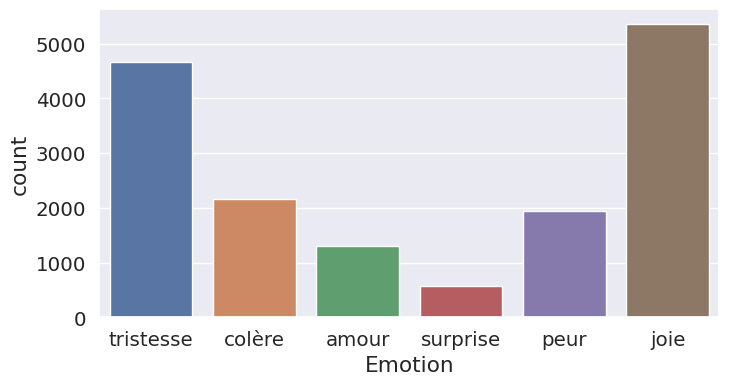

In [14]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train);

The data is imbalanced so, we may try to balance it but also, the emotions that we interested in are the most repeated emotion so, till now we can keep the data as it is

In [15]:
#print the number of null values in each column
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

The data doesn't contains any null values

In [16]:
#print the number of duplicated values 
df_train.duplicated().sum()

29

There is just one row which is duplicated but we need to check also if there are rows having the same text but different emotions

In [17]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [18]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
5064,"je me sens au bord des larmes de lassitude, je...",joie
6129,j'ai toujours envie de nourriture sucrée,amour
6559,j'ai tendance à arrêter de respirer quand je m...,colère
6992,je me sens un peu dépassé,surprise
7616,J'étais intensément conscient de la somme d'ar...,tristesse
7676,Je ne sais toujours pas pourquoi Reilly ressen...,surprise
7704,je me sens dépassé,peur
9586,Je l'ai aussi fait avec les deux mesures de su...,joie
9676,J'ai dû choisir la sensation élégante et plus ...,joie
9758,je me sens souvent agressé par une multitude d...,tristesse


In [19]:
#print some of those rows to check
df_train[df_train['Text'] == df_train.iloc[5064]['Text']]

,Text,Emotion
1501,"je me sens au bord des larmes de lassitude, je...",amour
5064,"je me sens au bord des larmes de lassitude, je...",joie


In [20]:
df_train[df_train['Text'] == df_train.iloc[15541]['Text']]


,Text,Emotion
8795,Je parie que Taylor Swift sait que les garçons...,peur
15541,Je parie que Taylor Swift sait que les garçons...,colère


In [21]:
df_train[df_train['Text'] == df_train.iloc[15300]['Text']]


,Text,Emotion
2948,je me méfie des chansons qui parlent de ce que...,amour
15300,je me méfie des chansons qui parlent de ce que...,joie


In [22]:
#removing duplicated text 
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [23]:
#Count the number of stopwords in the data
# Importer les stopwords en français depuis NLTK
from nltk.corpus import stopwords
stop_words_french = set(stopwords.words("french"))

# Copie du DataFrame pour éviter de modifier le DataFrame d'origine
temp = df_train.copy()

# Appliquer le comptage des stopwords en français dans la colonne 'Text'
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & stop_words_french))

# Afficher la distribution du nombre de mots vides par texte
print(temp['stop_words'].value_counts())


stop_words
4     1796
6     1744
5     1719
7     1616
3     1504
8     1412
9     1152
2     1072
10    1022
11     795
12     565
13     453
14     297
15     208
1      172
16     153
17      83
18      67
0       47
19      40
20      15
21       4
22       3
24       1
Name: count, dtype: int64


The data contains alot of stopwords (some rows contains more than 25 stopword!) so, we need to take care when we remove them as some rows may become empty 

<Axes: ylabel='Frequency'>

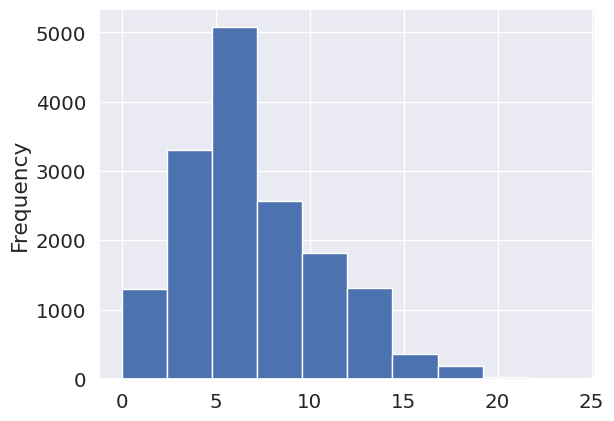

In [24]:
#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')


## Test dataset

In [25]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

Emotion
joie         694
tristesse    581
colère       275
peur         224
amour        159
surprise      66
Name: count, dtype: int64

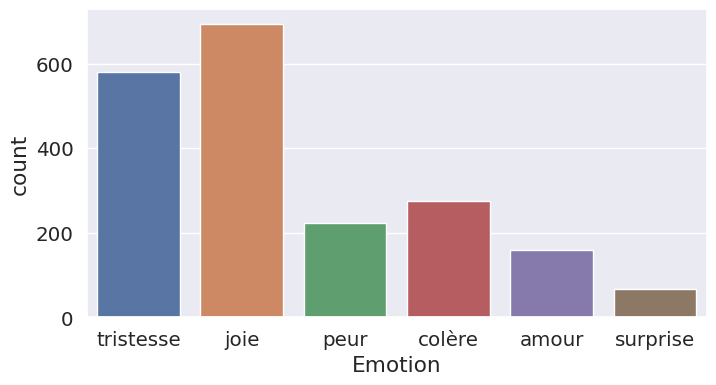

In [26]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);



In [27]:
#print the number of null values in each column
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [28]:
#print the number of duplicated values 
df_test.duplicated().sum()

1

In [29]:

#print the rows which are duplicated
df_test[df_test['Text'].duplicated() == True]



,Text,Emotion
960,je me sens à nouveau déprimé,tristesse


In [31]:
df_test.drop_duplicates(subset='Text', keep='first', inplace=True)

In [32]:
from nltk.corpus import stopwords
stop_words_french = set(stopwords.words("french"))

# Copie du DataFrame pour éviter de modifier le DataFrame d'origine
temp = df_test.copy()

# Appliquer le comptage des stopwords en français dans la colonne 'Text'
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & stop_words_french))

# Afficher la distribution du nombre de mots vides par texte
print(temp['stop_words'].value_counts())


stop_words
4     227
7     208
6     208
5     205
3     191
9     182
8     178
2     123
10    107
11     85
12     68
13     54
14     42
1      30
15     29
16     27
17     12
19      7
18      6
0       4
23      2
20      2
21      1
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

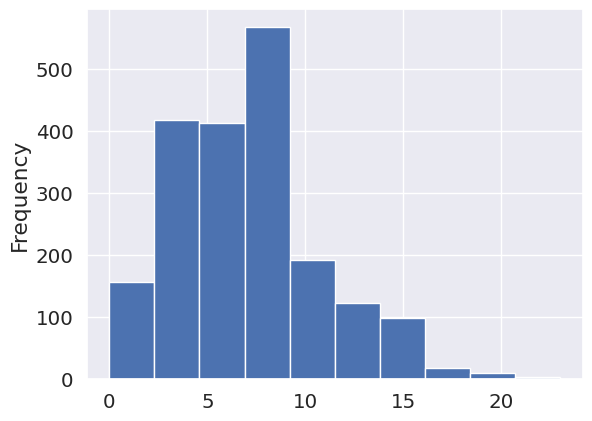

In [33]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

## Validation dataset

In [34]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

Emotion
joie         704
tristesse    550
colère       274
peur         212
amour        178
surprise      81
Name: count, dtype: int64

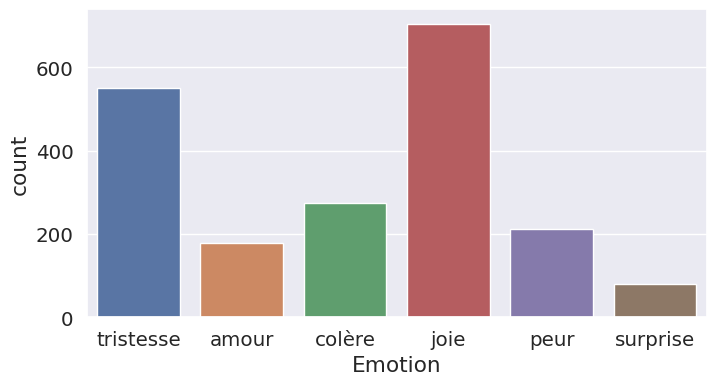

In [35]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [36]:
#print the number of null values in each column
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [37]:
#print the number of duplicated values 
df_val.duplicated().sum()

0

In [38]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion
602,Plusieurs nouveaux membres m'ont dit à quel po...,joie
1992,je me sens tellement torturé par ça,colère


In [39]:
df_val[df_val['Text'] == df_val.iloc[602]['Text']]


,Text,Emotion
299,Plusieurs nouveaux membres m'ont dit à quel po...,amour
602,Plusieurs nouveaux membres m'ont dit à quel po...,joie


In [40]:
df_val[df_val['Text'] == df_val.iloc[1992]['Text']]


,Text,Emotion
773,je me sens tellement torturé par ça,peur
1992,je me sens tellement torturé par ça,colère


In [41]:
#removing duplicated text
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [42]:
from nltk.corpus import stopwords
stop_words_french = set(stopwords.words("french"))

# Copie du DataFrame pour éviter de modifier le DataFrame d'origine
temp = df_val.copy()

# Appliquer le comptage des stopwords en français dans la colonne 'Text'
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & stop_words_french))

# Afficher la distribution du nombre de mots vides par texte
print(temp['stop_words'].value_counts())


stop_words
4     232
6     225
5     206
7     205
3     201
8     167
9     150
2     133
10    116
11     85
12     81
13     53
14     46
15     35
1      23
16     17
17      9
0       6
19      4
18      3
Name: count, dtype: int64


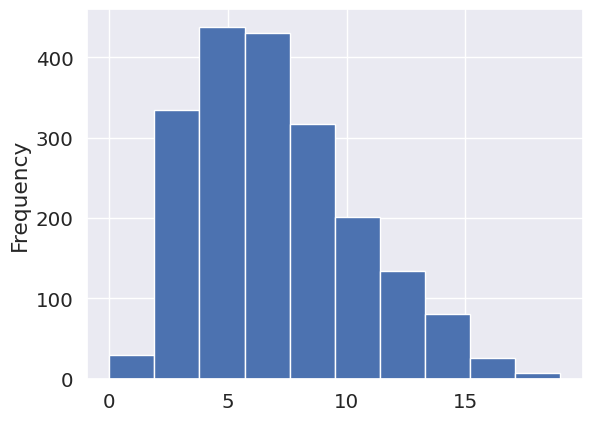

In [43]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

## Compare rows of the datasets

check that there is no data leakage fuite

In [44]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    
    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    # Return the filtered DataFrame
    return diff_df

In [45]:
dataframe_difference(df_train, df_test, which='both')

,Text,Emotion,_merge


In [46]:
dataframe_difference(df_train, df_val, which='both')

,Text,Emotion,_merge


In [47]:
dataframe_difference(df_val, df_test, which='both')

,Text,Emotion,_merge
1671,je me sens un peu insatisfait,colère,both


## Cleaning

In [48]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [49]:
!pip install -q spacy
!python -m spacy download fr_core_news_sm



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 49.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [50]:
import spacy

# Charger le modèle de langue français
nlp = spacy.load('fr_core_news_sm')

In [51]:

def lemmatization_french(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc])
    return lemmatized_text

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words_french]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization_french(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization_french(sentence)
    return sentence

    

In [53]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [54]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

## Modeling

### TF-IDF    importance des mots dans notre datasets
The word counts suffer some issues: most frequent words are usually not important (like stop words), while they take high focus/count.

TFIDF (Term Frequency - Inverse Document) is a way to adjust those counts:

TF: #mentions within a document

IDF: #mentions across all docs 

So it gives higher importance to rare words across all docs (IDF++, TFIDF--), while it emphasyses on words appearing mostly in THIS doc (TF++, TFIDF--).

If a word appearing only in the current doc/sentence, it has TFIDF=1. If a word appears in all docs/sents but not the current one, it has TFIDF=0. If a word (stop word for example) appearing a lot in the current doc/sent and also in ALL others, it will have high TF (count) and much higher IDF (discount), so low TFIDF overall.

We will start by baseline models

**Creating a pipline using tf-idf for words embedding and different models.**


In [55]:
#Preprocess text
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [56]:
def train_model(model, data, targets):
    """
    Train a model on the given data and targets.
    
    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.
    
    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [57]:
def get_F1(trained_model,X,y):
    """
    Get the F1 score for the given model on the given data and targets.
    
    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.
    
    Returns:
    array: The F1 score for each class.
    """
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

**Training the Logistic Regression model on the Training set**


In [58]:
#Train the model with the training data
log_reg = train_model(LogisticRegression(solver='liblinear',random_state = 0), X_train, y_train)

In [59]:
#Make a single prediction
y_pred=log_reg.predict(['Happy'])
y_pred

array(['joie'], dtype=object)

In [60]:
#test the model with the test data
y_pred=log_reg.predict(X_test)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(log_reg,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.7692692692692693 



,F1 score
tristesse,0.401709
colère,0.744939
amour,0.826087
surprise,0.678663
peur,0.600000
joie,0.819753


#les classes ne sont pas equilibré

In [61]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       amour       0.63      0.30      0.40       159
      colère       0.84      0.67      0.74       275
        joie       0.74      0.93      0.83       694
        peur       0.80      0.59      0.68       224
    surprise       0.88      0.45      0.60        66
   tristesse       0.78      0.86      0.82       580

    accuracy                           0.77      1998
   macro avg       0.78      0.63      0.68      1998
weighted avg       0.77      0.77      0.76      1998



**Training the Decision Tree model on the Training set**

In [62]:
#Train the model with the training data
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=DT.predict(X_test)

#calculate the accuracy
DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(DT,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.7027027027027027 



,F1 score
tristesse,0.465409
colère,0.723247
amour,0.725677
surprise,0.666667
peur,0.571429
joie,0.758621


In [63]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       amour       0.47      0.47      0.47       159
      colère       0.73      0.71      0.72       275
        joie       0.74      0.71      0.73       694
        peur       0.67      0.67      0.67       224
    surprise       0.57      0.58      0.57        66
   tristesse       0.74      0.78      0.76       580

    accuracy                           0.70      1998
   macro avg       0.65      0.65      0.65      1998
weighted avg       0.70      0.70      0.70      1998



**Training the Support Vector Machine model on the Training set**


In [64]:
#Train the model with the training data
SVM = train_model(SVC(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=SVM.predict(X_test)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 


Accuracy:  0.7647647647647647 



,F1 score
tristesse,0.394850
colère,0.725773
amour,0.823980
surprise,0.682927
peur,0.600000
joie,0.816667


In [65]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       amour       0.62      0.29      0.39       159
      colère       0.84      0.64      0.73       275
        joie       0.74      0.93      0.82       694
        peur       0.75      0.62      0.68       224
    surprise       0.88      0.45      0.60        66
   tristesse       0.79      0.84      0.82       580

    accuracy                           0.76      1998
   macro avg       0.77      0.63      0.67      1998
weighted avg       0.76      0.76      0.75      1998



**Training the Random Forest model on the Training set**

In [66]:
#Train the model with the training data
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=RF.predict(X_test)

#calculate the accuracy
RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.7797797797797797 



,F1 score
tristesse,0.518219
colère,0.770138
amour,0.829553
surprise,0.699029
peur,0.654867
joie,0.813993


In [67]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       amour       0.73      0.40      0.52       159
      colère       0.84      0.71      0.77       275
        joie       0.75      0.92      0.83       694
        peur       0.77      0.64      0.70       224
    surprise       0.79      0.56      0.65        66
   tristesse       0.81      0.82      0.81       580

    accuracy                           0.78      1998
   macro avg       0.78      0.68      0.71      1998
weighted avg       0.78      0.78      0.77      1998



## Results

In [68]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Support Vector Machine','Random Forest'],
    'Accuracy': [log_reg_accuracy.round(2), DT_accuracy.round(2), SVM_accuracy.round(2), RF_accuracy.round(2)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

,Model,Accuracy
0,Random Forest,0.78
1,Logistic Regression,0.77
2,Support Vector Machine,0.76
3,Decision Tree,0.70


# Lime

LIME, the acronym for local interpretable model-agnostic explanations, is a technique that approximates any black box machine learning model with a local, interpretable model to explain each individual prediction

we need which words contributed the most in the predicition

In [72]:
#c_LR = make_pipeline(tfidf, clf)
explainer_LR = LimeTextExplainer(class_names=RF.classes_)
idx  = 15
print("Actual Text : ", X_test[idx])
print("Prediction : ", RF.predict(X_test)[idx])
print("Actual :     ", y_test[idx])
exp = explainer_LR.explain_instance(X_test[idx], RF.predict_proba,top_labels=5)
exp.show_in_notebook()

Actual Text :  j avoir cœur aussi briser katnis j en sûr
Prediction :  tristesse
Actual :      tristesse


# Better way?
Word embedding using this glove and use a sequance model 

## Text Preprocessing

In [74]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [75]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [76]:
#print the labels after encoding 
print(set(y_train))

{0, 1, 2, 3, 4, 5}


In [77]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [78]:
print(y_train)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


## Tokenizing

In [79]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [80]:
# word index: A dictionary of words and their uniquely assigned integers.
tokenizer.word_index

{'UNK': 1,
 'avoir': 2,
 'j': 3,
 'sens': 4,
 'l': 5,
 'd': 6,
 'être': 7,
 'sentir': 8,
 'faire': 9,
 'tout': 10,
 'plus': 11,
 'impression': 12,
 'si': 13,
 'peu': 14,
 'm': 15,
 'pouvoir': 16,
 'qu': 17,
 'il': 18,
 'un': 19,
 'c': 20,
 'chose': 21,
 'penser': 22,
 'comme': 23,
 'vraiment': 24,
 'parce': 25,
 'très': 26,
 'ce': 27,
 'n': 28,
 'dire': 29,
 'celer': 30,
 'tellement': 31,
 'sentiment': 32,
 'devoir': 33,
 'quelque': 34,
 'quand': 35,
 'ressentir': 36,
 'ne': 37,
 'toujours': 38,
 'autre': 39,
 'que': 40,
 'bien': 41,
 'aussi': 42,
 'aimer': 43,
 'mal': 44,
 'cela': 45,
 'juste': 46,
 'sen': 47,
 'temps': 48,
 'lui': 49,
 'aller': 50,
 'vie': 51,
 'savoir': 52,
 'moment': 53,
 's': 54,
 'veux': 55,
 'voir': 56,
 'peux': 57,
 'ressen': 58,
 'jour': 59,
 'beaucoup': 60,
 'alors': 61,
 'sans': 62,
 'commencer': 63,
 'passer': 64,
 'besoin': 65,
 'maintenant': 66,
 'personne': 67,
 'en': 68,
 'assez': 69,
 'où': 70,
 'moi': 71,
 'encore': 72,
 'seul': 73,
 'après': 74,
 'sa

In [ ]:
#word counts: A dictionary of words and their counts.
#tokenizer.word_counts

In [81]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

17938

In [ ]:
#word docs: An integer count of the total number of documents(or rows) that were used to fit the Tokenizer.
#tokenizer.word_docs

In [82]:
#print the index of a single word
tokenizer.word_index['sens']

4

In [83]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[8], [568]]

In [84]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [85]:
#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_train[0].split()).shape

(2, 13262)

In [86]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [ ]:
#print the sentence after converting them to indexes
#sequences_train

## Padding

The vectors we obtain are generally not of equal lengths

For that, we might need to pad the sequences to max len. 

In [87]:
df_test.shape

(1998, 2)

In [88]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

301

In [89]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 13262


In [90]:
#before
sequences_train[0]

[8, 568]

In [91]:
#after
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## Word Embedding

**This code defines the following variables:**

**path_to_glove_file**: The file path to the GloVe word vectors file.

**num_tokens**: The size of the vocabulary. This is typically the number of unique words in the dataset.

**embedding_dim**: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.) depending on the size of the word vectors file that is being used.

**hits**: A counter for the number of words that are found in the embeddings_index dictionary.

**misses**: A counter for the number of words that are not found in the embeddings_index dictionary.

**embeddings_index**: A dictionary that will store the word vectors, with the words as keys and the word vectors as values.

In [93]:
# Read GloVE embeddings

# path_to_glove_file = '../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 300 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

I will intialize an embedding matrix with all zero values and then looping through the vocabulary (as defined by the tokenizer object) to assign word vectors to the corresponding rows of the embedding matrix. The word_index attribute of the tokenizer object is a dictionary that maps words to their indices in the vocabulary.

The embedding matrix will have a size of num_tokens rows and embedding_dim columns, where num_tokens is the size of the vocabulary and embedding_dim is the dimensionality of the word vectors.

For each word in the vocabulary, the code looks up the corresponding word vector in the embeddings_index dictionary and assigns it to the corresponding row of the embedding matrix. If the word is not found in the embeddings_index dictionary (i.e., if embedding_vector is None), the code increments the misses counter and the row of the embedding matrix remains all-zeros. If the word is found in the embeddings_index dictionary, the code increments the hits counter and assigns the word vector to the corresponding row of the embedding matrix. Finally, the code prints out the number of words that were converted (hits) and the number that were not found in the embeddings_index dictionary (misses).

In [95]:
pip install flair


  Obtaining dependency information for flair from https://files.pythonhosted.org/packages/f0/e3/a1b157afb740defde094949443a088f5d0b3af46be6344fef71d589cb0e1/flair-0.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for conllu>=4.0 from https://files.pythonhosted.org/packages/ce/3f/70a1dc5bc536755ec082b806594598a10cfffaf0de978f51d4e0e4fdfa47/conllu-4.5.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for ftfy>=6.1.0 from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 30.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for transformer-smaller-training-vocab>=0.2.3 from https://files.pythonhosted.org/packages/62/5e/4ba6cea4bff1eb107012f9b1f139e4f0a7e0005e59ab67b26d0cbc0a9e5f/t

In [97]:
from flair.embeddings import WordEmbeddings
from flair.data import Sentence
import numpy as np

# Initialisation de l'embedding
embedding = WordEmbeddings('fr')  # Remplacez 'your_embedding_type' par le type d'embedding que vous souhaitez utiliser, par exemple 'fr-forward'

# Obtention des embeddings pour chaque mot de votre vocabulaire
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    sentence = Sentence(word)
    embedding.embed(sentence)
    embedding_vector = sentence[0].embedding.numpy()
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


## Modeling

**The model consists of several layers:**

1. An Embedding layer that takes in integer-encoded text and looks up the embedding vector for each word in the input. The input length is set to the length of the input sequences, and the weights are initialized with an embedding matrix that has been pre-trained on a large dataset. The embedding layer is not trainable, meaning that the weights of this layer will not be updated during training.

2. Three Bidirectional layers, each of which applies a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The dropout and recurrent dropout arguments specify the dropout rate to apply to the inputs and recurrent inputs of the LSTMs, respectively. The return_sequences argument specifies whether the LSTM should return the full sequences of outputs or just the last output of each sequence.

3. A Dense layer that applies a linear transformation to the input to produce the output. The output has 6 units and uses the 'softmax' activation function, which means that it will output a probability distribution over the 6 classes.

In [98]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 300)          3978600   
                                                                 
 bidirectional (Bidirection  (None, 229, 512)          1140736   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 229, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

**This is the summary of a deep learning model built using the Keras functional API. The model consists of several layers, each of which has a specific type and number of parameters.**

1. The first layer is an "Embedding" layer, which takes in integer-encoded text and looks up the embedding vector for each word in the input. The output of this layer is a 3D tensor with shape (batch_size, sequence_length, embedding_dim), where batch_size is the number of examples in the batch, sequence_length is the length of the input sequences, and embedding_dim is the size of the embedding vectors. In this case, the input sequences are 229 words long and the embedding vectors are 200 dimensions. The embedding layer has a total of 2,863,600 trainable parameters.

2. The next three layers are "Bidirectional" layers, which apply a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The output of each bidirectional layer is a 3D tensor with shape (batch_size, sequence_length, units), where units is the number of LSTM units in the layer. In this case, the first bidirectional layer has 512 units, the second has 256 units, and the third has 256 units. Each of these layers has a large number of trainable parameters, as LSTMs are complex models with many internal weights.

3. The final layer is a "Dense" layer, which applies a linear transformation to the input to produce the output. In this case, the output has shape (batch_size, 6), indicating that there are 6 classes. The dense layer has a total of 1,542 trainable parameters.

Overall, the model has a total of 4,851,702 trainable parameters and 2,863,600 non-trainable parameters.

In [99]:
!pip install graphviz
!pip install pydot



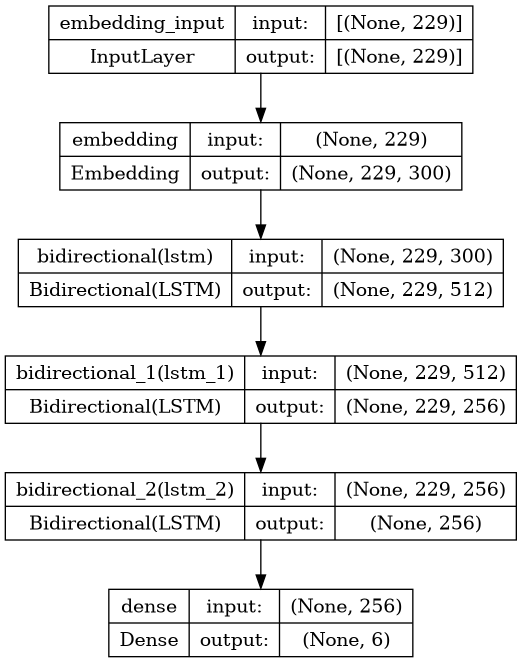

In [100]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)


In [101]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [ ]:
ggggffffGGGGGGFFGhhhhhhh

In [102]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10
63/63 [==============================] - 973s 15s/step - loss: 1.5724 - accuracy: 0.3639 - val_loss: 1.4963 - val_accuracy: 0.4417
Epoch 2/10
63/63 [==============================] - 937s 15s/step - loss: 1.3252 - accuracy: 0.5097 - val_loss: 1.1591 - val_accuracy: 0.5764
Epoch 3/10
63/63 [==============================] - 925s 15s/step - loss: 1.1410 - accuracy: 0.5945 - val_loss: 0.9101 - val_accuracy: 0.6820
Epoch 4/10
63/63 [==============================] - 920s 15s/step - loss: 0.8024 - accuracy: 0.7273 - val_loss: 0.6981 - val_accuracy: 0.7687
Epoch 5/10
63/63 [==============================] - 920s 15s/step - loss: 0.6368 - accuracy: 0.7790 - val_loss: 0.5802 - val_accuracy: 0.8002
Epoch 6/10
63/63 [==============================] - 929s 15s/step - loss: 0.5098 - accuracy: 0.8233 - val_loss: 0.5217 - val_accuracy: 0.8117
Epoch 7/10
63/63 [==============================] - 924s 15s/step - loss: 0.4301 - accuracy: 0.8486 - val_loss: 0.4844 - val_accuracy: 0.8338
Epoch 

In [103]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1) 

63/63 [==============================] - 48s 756ms/step - loss: 0.5083 - accuracy: 0.8388


[0.5082687139511108, 0.838758111000061]

In [104]:
#print the overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1) 

63/63 [==============================] - 48s 759ms/step - loss: 0.5419 - accuracy: 0.8213


[0.5419236421585083, 0.8213213086128235]

In [105]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['Emotion']), y_pred))

63/63 [==============================] - 50s 758ms/step
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       159
           1       0.81      0.75      0.78       275
           2       0.85      0.88      0.87       694
           3       0.82      0.73      0.77       224
           4       0.65      0.80      0.72        66
           5       0.88      0.85      0.86       580

    accuracy                           0.82      1998
   macro avg       0.77      0.79      0.78      1998
weighted avg       0.82      0.82      0.82      1998



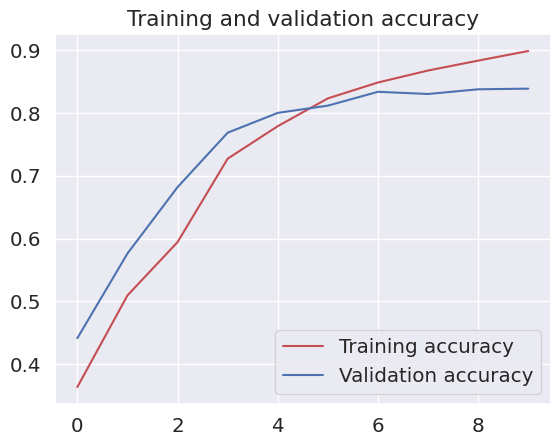

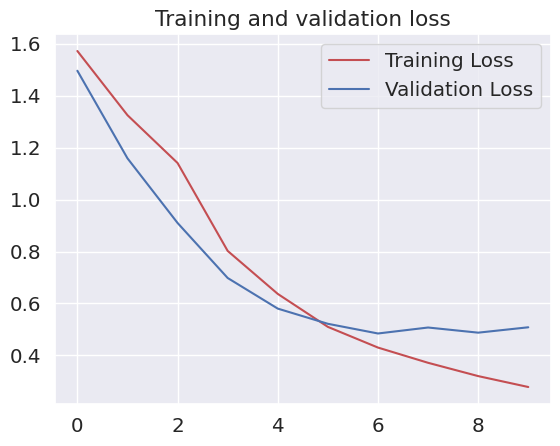

In [106]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**So, you may asking when I give a sentence to the model how the classification will done?**

1. First, the model will convert the words in the sentence into numerical representations, also known as word embeddings. These word embeddings capture the meaning of the words and their relationships to each other in a continuous vector space.

2. The word embeddings for each word in the sentence are then input to two separate LSTM models: one that processes the sequence forwards and one that processes it backwards. At each time step, each LSTM processes the current word embedding and the previous hidden state to produce a new hidden state. The hidden state at each time step is a combination of the previous hidden state and the current input, and it captures the information from all the previous time steps in the sequence.

3. After processing all the words in the sentence, the two LSTMs will have final hidden states that encode the meaning of the sentence from both the forwards and backwards directions. These final hidden states are then combined and used to make a prediction.

In [107]:
# Classify custom sample

sentences = [
            "Il est ravi d'avoir été accepté à l'université",
            "Votre argument sur ce sujet m'a rendu scandaleux, comment pouvez-vous le dire ? C'est insensé.",
            "Je n'y arrive pas, je ne suis pas prêt à perdre quoi que ce soit, laisse-moi tranquille",
            "La barbe de Merlin Harry, tu peux lancer le charme Patronus ! Je suis étonné !"
            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

Il est ravi d'avoir été accepté à l'université
1/1 [==============================] - 0s 331ms/step
joie : 0.996086597442627


Votre argument sur ce sujet m'a rendu scandaleux, comment pouvez-vous le dire ? C'est insensé.
1/1 [==============================] - 0s 325ms/step
tristesse : 0.9923592209815979


Je n'y arrive pas, je ne suis pas prêt à perdre quoi que ce soit, laisse-moi tranquille
1/1 [==============================] - 0s 323ms/step
joie : 0.6073273420333862


La barbe de Merlin Harry, tu peux lancer le charme Patronus ! Je suis étonné !
1/1 [==============================] - 0s 325ms/step
surprise : 0.9470130205154419




In [108]:
sentence= 'mon vieux frère est mort'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

mon vieux frère est mort
1/1 [==============================] - 0s 309ms/step
tristesse : 0.96717768907547




In [109]:
sentence= "Je me sens triste aujourd'hui"
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

Je me sens triste aujourd'hui
1/1 [==============================] - 0s 310ms/step
tristesse : 0.9987128973007202




In [113]:
model.save('Emotion Recognition From frensh text.h5')